In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud

### READ ANIMELIST.CSV DATA

In [2]:
import os

In [4]:
INPUT_DIR = os.path.join("..","artifacts", "raw")

In [5]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols=["user_id","anime_id", "rating"])

In [6]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [7]:
len(rating_df)

5000000

### DATA PROCESSING

In [8]:
n_ratings = rating_df["user_id"].value_counts()

In [9]:
n_ratings

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [10]:
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()

In [11]:
len(rating_df)

3246641

In [12]:
min_rating = min(rating_df["rating"])

In [13]:
max_rating = max(rating_df["rating"])

In [14]:
avg_rating = np.mean(rating_df["rating"])

In [15]:
min_rating, max_rating, avg_rating

(0, 10, np.float64(4.122732695114736))

In [16]:
rating_df["rating"] = rating_df["rating"].apply(lambda x: (x - min_rating)/(max_rating - min_rating)).values.astype(np.float64)

In [17]:
min_rating, max_rating, avg_rating

(0, 10, np.float64(4.122732695114736))

In [18]:
rating_df.duplicated().sum()

np.int64(0)

In [19]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [20]:
user_ids = rating_df["user_id"].unique().tolist()

user2user_encoded = {x : i for i, x in enumerate(user_ids)}

In [21]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [22]:
user2user_decoded = {i : x for i, x in enumerate(user_ids)}

In [23]:
user2user_decoded

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

In [24]:
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [25]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [26]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x : i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i : x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [27]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [28]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [29]:
rating_df.head()

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353


In [30]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"]

In [31]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size

In [32]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

In [33]:
len(X_train), len(X_test)

(3245641, 1000)

In [34]:
type(X_train)

numpy.ndarray

In [35]:
X_train_array = [X_train[: , 0], X_train[: , 1]]
X_test_array = [X_test[: , 0], X_test[: , 1]]

In [36]:
type(X_train_array), type(X_test_array)

(list, list)

In [37]:
n_users = len(user2user_encoded)

### MODEL ARCHITECTURE

In [39]:
def RecommenderNet():
    embedding_size = 128

    user = Input(name="user", shape=[1])
    user_embedding = Embedding(name="user_embedding", input_dim=n_users, output_dim=embedding_size)(user)

    anime = Input(name="anime", shape=[1])
    anime_embedding = Embedding(name="anime_embedding", input_dim=n_anime, output_dim=embedding_size)(anime)

    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])

    x = Flatten()(x)

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss="binary_crossentropy", metrics=["mae","mse"], optimizer='Adam')

    return model



In [40]:
model = RecommenderNet()

In [41]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [42]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs*epoch + start_lr
    elif epoch < rampup_epochs+sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay ** (epoch - rampup_epochs - sustain_epochs) + min_lr



In [43]:
lr_callback = LearningRateScheduler(lambda epoch:lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor="val_loss", mode="min", save_best_only=True)

early_stopping = EarlyStopping(patience=3, monitor="val_loss", mode="min", restore_best_weights=True)


In [44]:
my_callbacks = [model_checkpoint, lr_callback, early_stopping]

In [45]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data = (X_test_array, y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 44s 117ms/step - loss: 0.6955 - mae: 0.3617 - mse: 0.1567 - val_loss: 0.6927 - val_mae: 0.3607 - val_mse: 0.1555 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 38s 115ms/step - loss: 0.6945 - mae: 0.3613 - mse: 0.1562 - val_loss: 0.6924 - val_mae: 0.3607 - val_mse: 0.1554 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 38s 115ms/step - loss: 0.6931 - mae: 0.3611 - mse: 0.1556 - val_loss: 0.6916 - val_mae: 0.3606 - val_mse: 0.1550 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 38s 115ms/step - loss: 0.6916 - mae: 0.3607 - mse: 0.1547 - val_loss: 0.6913 - val_mae: 0.3606 - val_mse: 0.1548 - learning_rate: 3.4000e-05
Epoch 5/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 38s 115ms/step - loss: 0.6899 - mae: 0.3605 - mse: 0.1540 - val_loss: 0.6888 - val_mae: 0.3605 - val_mse: 0.1536 - learning_rate: 4.2000e-05
Epoch 6/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 38s 117ms/step - loss: 0.6881 - mae: 0.3601 - mse: 0.15

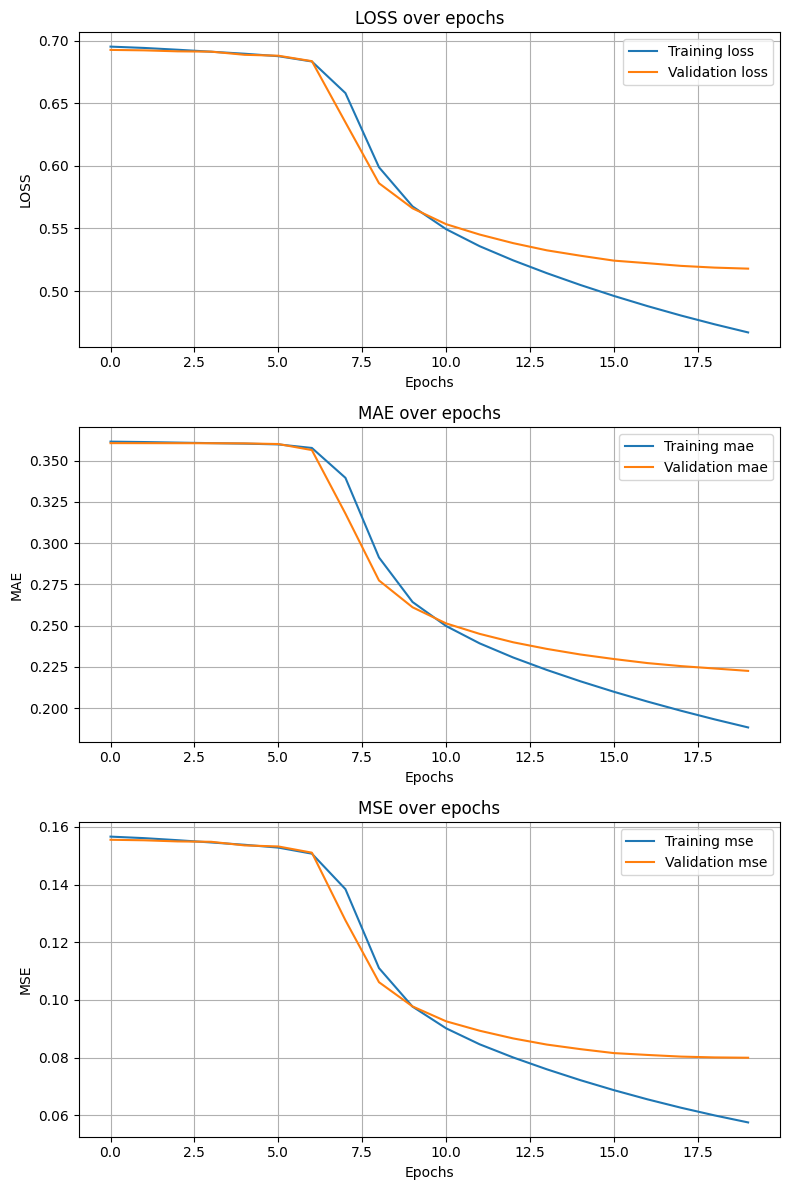

In [46]:
metrics = ["loss", "mae", "mse"]

#Create subplot
fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

# If there's only one metric, axes is not an array, so handle that
if len(metrics) == 1:
    axes = [axes]

# Assume `history` is the history object returned by model.fit()
# Example: history.history = {'loss': [...], 'val_loss': [...], 'mae': [...], 'val_mae': [...], ...}

for i, metric in enumerate(metrics):
    ax = axes[i]
    
    # Plot training metric
    ax.plot(history.history[metric], label=f'Training {metric}')
    
    # Plot validation metric if exists
    if f'val_{metric}' in history.history:
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
    
    ax.set_title(f'{metric.upper()} over epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric.upper())
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [47]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [48]:
anime_weights = extract_weights("anime_embedding", model)

In [49]:
user_weights = extract_weights("user_embedding", model)

### READING ANIME.CSV

In [50]:
df = pd.read_csv(INPUT_DIR+"/anime.csv",low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [51]:
df = df.replace("Unknown", np.nan)

In [52]:
def getAnimeName(anime_id, df):
    try:
        matching_row = df[df.anime_id == anime_id]
        if matching_row.empty:
            return "Anime not found"  # or some default value like "Anime not found"
        name = matching_row['eng_version'].values[0]
        if pd.isna(name):
            name = matching_row['Name'].values[0]
        return name
    except Exception as e:
        print(f"Error: {e}")
        return "Anime not found"  # or some default value

In [53]:
df["anime_id"] = df["MAL_ID"]
# Directly compute eng_version using a vectorized approach
df["eng_version"] = df["English name"].where(df["English name"].notna(), df["Name"])

df["eng_version"] = df.anime_id.apply(lambda x:getAnimeName(x, df))

In [54]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster


In [55]:
df.sort_values(
    by=["Score"],
    inplace=True,
    ascending=False,
    kind="quicksort",
    na_position="last"
)

In [56]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [57]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [58]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Type", "Episodes", "Premiered", "Members"]]

In [59]:
df.head()

,anime_id,eng_version,Score,Genres,Type,Episodes,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",TV,64,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",TV,16,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",TV,24,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",TV,10,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,Spring 2015,404121


In [60]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [61]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Type,Episodes,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",TV,16,Winter 2021,733260


In [62]:
getAnimeFrame("Steins;Gate", df)

,anime_id,eng_version,Score,Genres,Type,Episodes,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",TV,24,Spring 2011,1771162


### ANIME WITH SYNOPSIS

In [63]:
cols = ["MAL_ID", "Name", "Genres", "sypnopsis"]

In [64]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [65]:
synopsis_df.head()

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of ..."
2,6,Trigun,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen","Vash the Stampede is the man with a $$60,000,0..."
3,7,Witch Hunter Robin,"Action, Mystery, Police, Supernatural, Drama, ...",ches are individuals with special powers like ...
4,8,Bouken Ou Beet,"Adventure, Fantasy, Shounen, Supernatural",It is the dark century and the people are suff...


In [66]:
def getSynopsis(anime, df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID == anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name == anime].sypnopsis.values[0]

In [67]:
getSynopsis(40028, synopsis_df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [68]:
getSynopsis("Trigun", synopsis_df)

'Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he\'s a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title "The Humanoid Typhoon." He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash\'s agonizing past will be unraveled and his morality and principles pushed to the breakin

### CONTENT / ITEM BASED RECOMMENDATION SYSTEM

In [69]:
pd.set_option("max_colwidth", None)

In [70]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [72]:
def find_similar_animes(name, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoded.get(index)

        weights = anime_weights

        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print(f"Anime closes to {name}")

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close  in closest:
            decoded_id = anime2anime_decoded.get(close)

            synopsis = getSynopsis(decoded_id, synopsis_df)

            anime_frame = getAnimeFrame(decoded_id, df)

            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id" : decoded_id,
                "name" : anime_name,
                "similarity" : similarity,
                "genre" : genre,
                "synopsis" : synopsis
            })

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"], axis=1)
    except:
        print("Error occured")


In [73]:
find_similar_animes(
    "Trigun",
    anime_weights,
    anime2anime_encoded,
    anime2anime_decoded,
    df,
    synopsis_df,
    n=2
)

Anime closes to Trigun


,name,similarity,genre,synopsis
1,Black Lagoon,0.488357,"Action, Seinen","hin Thailand is Roanapur, a depraved, crime-ridden city where not even the authorities or churches are untouched by the claws of corruption. A haven for convicts and degenerates alike, the city is notorious for being the center of illegal activities and operations, often fueled by local crime syndicates. Enter Rokurou Okajima, an average Japanese businessman who has been living a dull and monotonous life, when he finally gets his chance for a change of pace with a delivery trip to Southeast Asia. His business trip swiftly goes downhill as Rokurou is captured by a mercenary group operating in Roanapur, called Black Lagoon. The group plans to use him as a bargaining chip in negotiations which ultimately failed. Now abandoned and betrayed by his former employer, Rokurou decides to join Black Lagoon. In order to survive, he must quickly adapt to his new environment and prepare himself for the bloodshed and tribulation to come. A non-stop, high-octane thriller, Black Lagoon delves into the depths of human morality and virtue. Witness Rokurou struggling to keep his values and philosophies intact as he slowly transforms from businessman to ruthless mercenary."
0,Outlaw Star,0.480942,"Action, Sci-Fi, Adventure, Space, Comedy","Gene Starwind has always dreamed of piloting his own ship out into the vast sea of stars. Unfortunately, not all dreams come true, as he spends his days working odd jobs alongside his partner, James Hawking, on the small planet Sentinel III instead. However, this all takes a turn when the duo takes on a job from Rachel Sweet who, unbeknownst to them, is actually a treasure-hunting outlaw. Tasked with protecting a mysterious girl known as Melfina, the meeting irrevocably changes the pair's lives as they are sent out into the great unknown aboard the highly advanced ship, Outlaw Star. Seihou Bukyou Outlaw Star follows Gene and his ragtag crew as they brave the final frontier, navigating the stars in search of answers to the mysteries surrounding Melfina. Encountering dangerous bounty hunters, space pirates, Taoist mages, and even catgirls, there is sure to be an exhilarating adventure around every corner."


### USER BASED RECOMMENDATION

In [74]:
def find_similar_users(item_input, user_weights, user2user_encoded, user2user_decoded, n=10, return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)

        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1

        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print(f"Anime closes to {item_input}")

        if return_dist:
            return dists, closest
        
        SimilarityArr = []

        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = user2user_decoded.get(close)
                SimilarityArr.append({
                    "similar_users" : decoded_id,
                    "similarity" : similarity
                })

        similar_users = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        similar_users = similar_users[similar_users.similar_users != item_input]
        return similar_users
                

        


    except Exception as e:
        print("Error", e)


In [75]:
find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

Anime closes to 11880


,similar_users,similarity
9,7794,0.447275
8,13782,0.431477
7,12783,0.427641
6,9166,0.422741
5,3106,0.413839
4,12332,0.404709
3,15692,0.403896
2,10911,0.402049
1,16452,0.400336
0,8182,0.399927


In [76]:
def showWordCloud(all_generes):
    genres_cloud = WordCloud(width=700, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_generes)
    plt.Figure(figsize=(10,8))
    plt.imshow(genres_cloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [77]:
from collections import defaultdict

In [78]:
def getFavGenre(frame, plot=False):
    frame.dropna(inplace=False)
    all_generes = defaultdict(int)

    generes_list = []

    for generes in frame["Genres"]:
        if isinstance(generes, str):
            for genre in generes.split(','):
                generes_list.append(genre)
                all_generes[genre.strip()] += 1

    if plot:
        showWordCloud(all_generes)

    return generes_list

In [79]:
x = getAnimeFrame(1, df)

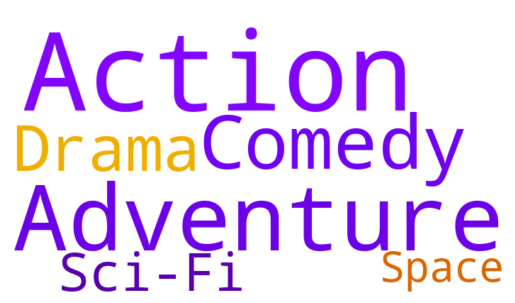

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [80]:
getFavGenre(x, plot=True)

In [81]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [82]:
def get_user_preferences(user_id, rating_df, df, plot=False):

    animes_watched_by_user = rating_df[rating_df.user_id == user_id]

    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)

    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]

    top_animes_by_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False).anime_id.values
    )

    anime_df_rows = df[df["anime_id"].isin(top_animes_by_user)]
    anime_df_rows = anime_df_rows[["eng_version", "Genres"]]

    if plot:
        getFavGenre(anime_df_rows, plot)

    return anime_df_rows

In [83]:
get_user_preferences(11880, rating_df, df, plot=False)

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9913,Gintama Season 4,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen"
6474,Hunter x Hunter,"Action, Adventure, Fantasy, Shounen, Super Power"
6006,Gintama Season 2,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen"
741,Legend of the Galactic Heroes,"Military, Sci-Fi, Space, Drama"
...,...,...
2575,Shootfighter Tekken,"Action, Martial Arts, Shounen"
8064,Samurai Flamenco,"Action, Comedy, Parody, Super Power"
510,Venus Wars,"Action, Sci-Fi, Adventure, Space"
6864,Saint Seiya Omega,"Action, Adventure, Fantasy, Shounen"


### USER BASED RECOMMENDATION

In [84]:
def get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=10):

    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), rating_df, df, plot=False)

        pref_list = pref_list[pref_list['eng_version'].isin(user_pref['eng_version'].to_numpy())]

        if not pref_list.empty:
            #anime_list.append(pref_list.eng_version.values)
            anime_list.extend(pref_list['eng_version'].values)

    if anime_list:
            anime_list = pd.DataFrame(anime_list)

            sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)

            for i, anime_name in enumerate(sorted_list.index):
                n_user_pref = sorted_list[sorted_list.index == anime_name].values[0][0]

                if isinstance(anime_name, str):
                    frame = getAnimeFrame(anime_name, df)
                    anime_id = frame.anime_id.values[0]
                    genre = frame.Genres.values[0]

                    synopsis = getSynopsis(int(anime_id), synopsis_df)

                    recommended_animes.append({
                        "n" : n_user_pref,
                        "anime_name" : anime_name,
                        "Genres" : genre,
                        "Synopsis" : synopsis
                    })

    return pd.DataFrame(recommended_animes).head(n)





In [85]:
similar_users = find_similar_users(int(11880), user_weights, user2user_encoded, user2user_decoded)

Anime closes to 11880


In [86]:
user_pref = get_user_preferences(11880, rating_df, df, plot=False)

In [87]:
get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df, n=2)

,n,anime_name,Genres,Synopsis
0,9,Bakuman.,"Comedy, Drama, Romance, Shounen","Onto their third serialization, manga duo Moritaka Mashiro and Akito Takagi—also known by their pen name, Muto Ashirogi—are ever closer to their dream of an anime adaption. However, the real challenge is only just beginning: if they are unable to compete with the artist Eiji Niizuma in the rankings within the span of six months, they will be canceled. To top it off, numerous rivals are close behind and declaring war. They don't even have enough time to spare thinking about an anime! In Bakuman. 3rd Season , Muto Ashirogi must find a way to stay atop the colossal mountain known as the Shounen Jack rankings. With new problems and new assistants, the pair continue to strive for their dream."
1,7,One Punch Man,"Action, Sci-Fi, Comedy, Parody, Super Power, Supernatural","The seemingly ordinary and unimpressive Saitama has a rather unique hobby: being a hero. In order to pursue his childhood dream, he trained relentlessly for three years—and lost all of his hair in the process. Now, Saitama is incredibly powerful, so much so that no enemy is able to defeat him in battle. In fact, all it takes to defeat evildoers with just one punch has led to an unexpected problem—he is no longer able to enjoy the thrill of battling and has become quite bored. This all changes with the arrival of Genos, a 19-year-old cyborg, who wishes to be Saitama's disciple after seeing what he is capable of. Genos proposes that the two join the Hero Association in order to become certified heroes that will be recognized for their positive contributions to society, and Saitama, shocked that no one knows who he is, quickly agrees. And thus begins the story of One Punch Man , an action-comedy that follows an eccentric individual who longs to fight strong enemies that can hopefully give him the excitement he once felt and just maybe, he'll become popular in the process."


### HYBRID RECOMMENDER SYSTEM

In [88]:
def hybrid_recommendation(user_id, user_weight=0.5, content_weight=0.5):

    ## user recommendation

    similar_users = find_similar_users(user_id, user_weights, user2user_encoded, user2user_decoded)
    user_pref = get_user_preferences(user_id, rating_df, df, plot=False)
    user_recommended_animes = get_user_recommendations(similar_users, user_pref, df, synopsis_df, rating_df)

    user_recommended_anime_list = user_recommended_animes["anime_name"].to_list()

    ## content recommendation

    content_recommended_animes = []

    for anime in user_recommended_anime_list:
        similar_animes = find_similar_animes(anime, anime_weights, anime2anime_encoded, anime2anime_decoded, df, synopsis_df)
        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].tolist())
        else:
            print(f"No similar animes found {anime}")

    combined_scores = {}

    for anime in user_recommended_anime_list:
        combined_scores[anime] = combined_scores.get(anime, 0) + user_weight
    for conent in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime, 0) + content_weight

    sorted_animes = sorted(combined_scores.items(), key=lambda x:x[1], reverse=True)

    return [anime for anime, score in sorted_animes[:10]]




In [89]:
hybrid_recommendation(11880)

Anime closes to 11880
Anime closes to Bakuman.
Anime closes to One Punch Man
Anime closes to Fullmetal Alchemist:Brotherhood
Anime closes to Spice and Wolf
Anime closes to ERASED
Anime closes to Spice and Wolf II
Anime closes to Bakemonogatari
Anime closes to Food Wars! The Second Plate
Anime closes to Welcome to the N.H.K.
Anime closes to Monogatari Series:Second Season


['Monogatari Series:Second Season',
 'Bakuman.',
 'One Punch Man',
 'Fullmetal Alchemist:Brotherhood',
 'Spice and Wolf',
 'ERASED',
 'Spice and Wolf II',
 'Bakemonogatari',
 'Food Wars! The Second Plate',
 'Welcome to the N.H.K.']

In [90]:
hybrid_recommendation(13994)

Anime closes to 13994
Anime closes to Steins;Gate
Anime closes to The Disappearance of Haruhi Suzumiya
Anime closes to Clannad ~After Story~
Anime closes to Code Geass:Lelouch of the Rebellion
Anime closes to Gurren Lagann
Anime closes to Fate/Zero Season 2
Anime closes to Code Geass:Lelouch of the Rebellion R2
Anime closes to Fate/Zero
Anime closes to Psycho-Pass
Anime closes to Bakemonogatari


['Bakemonogatari',
 'Steins;Gate',
 'The Disappearance of Haruhi Suzumiya',
 'Clannad ~After Story~',
 'Code Geass:Lelouch of the Rebellion',
 'Gurren Lagann',
 'Fate/Zero Season 2',
 'Code Geass:Lelouch of the Rebellion R2',
 'Fate/Zero',
 'Psycho-Pass']